# __Predicting Outcomes of Call Option Contracts with Multi-Class Classification Deep Learning__

# SECTION 1: Preparation

##  1.1.) Loading the Python packages

In [37]:
#General libraries 

import pandas as pd
from pathlib import Path

#General maching learning libraries

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, GridSearchCV

#For plotting

import matplotlib.pyplot as plt
%matplotlib inline

#Libraries for Deep Learning Models

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD
from scikeras.wrappers import KerasClassifier, KerasRegressor

from keras.callbacks import EarlyStopping


## 1.2.) Loading the Data

In [2]:
# Read in the options contract csv file from the Resources folder into a Pandas DataFrame

df = pd.read_csv(
    Path("../Resources/vix_spy_continual.csv")
)

df.head()

,CONTRACT,SPY PRICE,EXPIRE_DATE,DTE,C_DELTA,C_GAMMA,C_VEGA,C_THETA,C_RHO,C_IV,C_VOLUME,C_LAST,STRIKE,STRIKE_DISTANCE_PCT,STRIKE DISTANCE,PRICECLOSE,ROI %,y,VIX PRICE
0,474.0 2022-01-07,476.43,1/7/2022,4.27,0.62598,0.05055,0.21136,-0.28773,0.03788,0.13515,1,4.26,474,0.005,-2.43,0.55,-87.089202,0.0,17.68
1,475.0 2022-01-07,476.43,1/7/2022,4.27,0.57735,0.05466,0.21805,-0.28592,0.03511,0.12942,32,3.62,475,0.003,-1.43,0.39,-89.226519,0.0,17.68
2,476.0 2022-01-07,476.43,1/7/2022,4.27,0.52223,0.05633,0.22191,-0.28818,0.03208,0.12704,22,3.04,476,0.001,-0.43,0.29,-90.460526,0.0,17.68
3,477.0 2022-01-07,476.43,1/7/2022,4.27,0.46442,0.05760,0.22168,-0.28057,0.02945,0.12402,161,2.46,477,0.001,0.57,0.21,-91.463415,0.0,17.68
4,478.0 2022-01-07,476.43,1/7/2022,4.27,0.40460,0.05815,0.21613,-0.26381,0.02541,0.11971,0,1.51,478,0.003,1.57,0.15,-90.066225,0.0,17.68


# SECTION 2: Exploratory Data Analysis

## 2.1.) Descriptive Statistics

In [3]:
df.shape

(15454, 19)

In [4]:
#Check for any null values and remove the null values
print('Null Values =', df.isnull().values.any())

#Drop NaNs
df.dropna()

Null Values = True


,CONTRACT,SPY PRICE,EXPIRE_DATE,DTE,C_DELTA,C_GAMMA,C_VEGA,C_THETA,C_RHO,C_IV,C_VOLUME,C_LAST,STRIKE,STRIKE_DISTANCE_PCT,STRIKE DISTANCE,PRICECLOSE,ROI %,y,VIX PRICE
0,474.0 2022-01-07,476.43,1/7/2022,4.27,0.62598,0.05055,0.21136,-0.28773,0.03788,0.13515,1,4.26,474,0.005,-2.43,0.55,-87.089202,0.0,17.68
1,475.0 2022-01-07,476.43,1/7/2022,4.27,0.57735,0.05466,0.21805,-0.28592,0.03511,0.12942,32,3.62,475,0.003,-1.43,0.39,-89.226519,0.0,17.68
2,476.0 2022-01-07,476.43,1/7/2022,4.27,0.52223,0.05633,0.22191,-0.28818,0.03208,0.12704,22,3.04,476,0.001,-0.43,0.29,-90.460526,0.0,17.68
3,477.0 2022-01-07,476.43,1/7/2022,4.27,0.46442,0.05760,0.22168,-0.28057,0.02945,0.12402,161,2.46,477,0.001,0.57,0.21,-91.463415,0.0,17.68
4,478.0 2022-01-07,476.43,1/7/2022,4.27,0.40460,0.05815,0.21613,-0.26381,0.02541,0.11971,0,1.51,478,0.003,1.57,0.15,-90.066225,0.0,17.68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15449,455.0 2022-03-25,452.55,3/25/2022,0.00,0.00813,0.01376,0.00469,-0.00545,0.00020,0.10830,28006,0.01,455,0.005,2.45,0.13,1200.000000,5.0,20.84
15450,456.0 2022-03-25,452.55,3/25/2022,0.00,0.00641,0.00891,0.00322,-0.00479,0.00030,0.12766,12333,0.01,456,0.008,3.45,0.09,800.000000,5.0,20.84
15451,457.0 2022-03-25,452.55,3/25/2022,0.00,0.00626,0.00637,0.00281,-0.00530,0.00038,0.14620,6479,0.01,457,0.010,4.45,0.05,400.000000,5.0,20.84
15452,458.0 2022-03-25,452.55,3/25/2022,0.00,0.00476,0.00494,0.00258,-0.00533,0.00014,0.16389,2702,0.01,458,0.012,5.45,0.04,300.000000,5.0,20.84


In [5]:
display(df.head())
df.tail()

,CONTRACT,SPY PRICE,EXPIRE_DATE,DTE,C_DELTA,C_GAMMA,C_VEGA,C_THETA,C_RHO,C_IV,C_VOLUME,C_LAST,STRIKE,STRIKE_DISTANCE_PCT,STRIKE DISTANCE,PRICECLOSE,ROI %,y,VIX PRICE
0,474.0 2022-01-07,476.43,1/7/2022,4.27,0.62598,0.05055,0.21136,-0.28773,0.03788,0.13515,1,4.26,474,0.005,-2.43,0.55,-87.089202,0.0,17.68
1,475.0 2022-01-07,476.43,1/7/2022,4.27,0.57735,0.05466,0.21805,-0.28592,0.03511,0.12942,32,3.62,475,0.003,-1.43,0.39,-89.226519,0.0,17.68
2,476.0 2022-01-07,476.43,1/7/2022,4.27,0.52223,0.05633,0.22191,-0.28818,0.03208,0.12704,22,3.04,476,0.001,-0.43,0.29,-90.460526,0.0,17.68
3,477.0 2022-01-07,476.43,1/7/2022,4.27,0.46442,0.05760,0.22168,-0.28057,0.02945,0.12402,161,2.46,477,0.001,0.57,0.21,-91.463415,0.0,17.68
4,478.0 2022-01-07,476.43,1/7/2022,4.27,0.40460,0.05815,0.21613,-0.26381,0.02541,0.11971,0,1.51,478,0.003,1.57,0.15,-90.066225,0.0,17.68


,CONTRACT,SPY PRICE,EXPIRE_DATE,DTE,C_DELTA,C_GAMMA,C_VEGA,C_THETA,C_RHO,C_IV,C_VOLUME,C_LAST,STRIKE,STRIKE_DISTANCE_PCT,STRIKE DISTANCE,PRICECLOSE,ROI %,y,VIX PRICE
15449,455.0 2022-03-25,452.55,3/25/2022,0.0,0.00813,0.01376,0.00469,-0.00545,0.00020,0.10830,28006,0.01,455,0.005,2.45,0.13,1200.0,5.0,20.84
15450,456.0 2022-03-25,452.55,3/25/2022,0.0,0.00641,0.00891,0.00322,-0.00479,0.00030,0.12766,12333,0.01,456,0.008,3.45,0.09,800.0,5.0,20.84
15451,457.0 2022-03-25,452.55,3/25/2022,0.0,0.00626,0.00637,0.00281,-0.00530,0.00038,0.14620,6479,0.01,457,0.010,4.45,0.05,400.0,5.0,20.84
15452,458.0 2022-03-25,452.55,3/25/2022,0.0,0.00476,0.00494,0.00258,-0.00533,0.00014,0.16389,2702,0.01,458,0.012,5.45,0.04,300.0,5.0,20.84
15453,459.0 2022-03-25,452.55,3/25/2022,0.0,0.00503,0.00398,0.00258,-0.00451,-0.00019,0.18157,3424,0.01,459,0.014,6.45,0.03,200.0,5.0,20.84


In [6]:
df.describe()

,SPY PRICE,DTE,C_DELTA,C_GAMMA,C_VEGA,C_THETA,C_RHO,C_IV,C_VOLUME,C_LAST,STRIKE,STRIKE_DISTANCE_PCT,STRIKE DISTANCE,PRICECLOSE,ROI %,y,VIX PRICE
count,15454.000000,15454.000000,15454.000000,15454.000000,15454.000000,15454.000000,15454.000000,15299.000000,15454.000000,15454.000000,15454.000000,15454.000000,15454.000000,15454.000000,15454.000000,15454.000000,15454.000000
mean,444.959018,2.136380,0.314230,0.029056,0.095143,-0.365566,0.009728,0.258157,7390.752685,2.827980,450.517859,0.019303,5.558842,3.625001,991.548859,2.751456,25.787511
std,15.579653,1.415668,0.278475,0.023919,0.065542,0.311931,0.009326,0.100505,13405.350673,3.622754,16.586666,0.015027,9.204698,4.315542,4819.983128,1.958482,5.100686
min,410.870000,0.000000,0.001050,0.000000,0.000000,-2.590180,-0.000480,-0.000490,0.000000,0.010000,418.000000,0.000000,-26.270000,0.010000,-97.701149,0.000000,16.520000
25%,433.040000,1.060000,0.056155,0.013012,0.029882,-0.546242,0.001240,0.184850,609.000000,0.160000,439.000000,0.008000,-0.590000,0.220000,-39.166170,1.000000,21.940000
50%,444.050000,2.150000,0.252195,0.026190,0.099405,-0.344830,0.007720,0.242470,2403.500000,1.380000,447.000000,0.016000,5.500000,1.760000,18.487301,3.000000,25.540000
75%,456.100000,3.210000,0.512195,0.038950,0.151578,-0.081470,0.015590,0.310650,7488.750000,4.250000,462.000000,0.027000,11.490000,5.900000,193.030303,5.000000,29.990000
max,479.650000,4.270000,1.000000,0.536140,0.221910,0.000000,0.040320,0.901510,144660.000000,24.750000,491.000000,0.093000,40.840000,18.470000,108100.000000,5.000000,37.980000


In [7]:
df.dtypes

CONTRACT                object
SPY PRICE              float64
EXPIRE_DATE             object
DTE                    float64
C_DELTA                float64
C_GAMMA                float64
C_VEGA                 float64
C_THETA                float64
C_RHO                  float64
C_IV                   float64
C_VOLUME                 int64
C_LAST                 float64
STRIKE                   int64
STRIKE_DISTANCE_PCT    float64
STRIKE DISTANCE        float64
PRICECLOSE             float64
ROI %                  float64
y                      float64
VIX PRICE              float64
dtype: object

## 2.2.) Feature Analysis and Exploration

### Plotting features according to contract length

In [8]:
#
#contract_outcome = df.groupby('STRIKE_DISTANCE_PCT')['y'].value_counts(normalize=True).loc[:,1]
#sns.set(rc={'figure.figsize':(12,5)})
#sns.barplot(x=contract_outcome.index, y=contract_outcome.values, color='#5975A4', saturation=1)

### Eliminate Uncorrelated Features

In [9]:
#Calculate correlation of each feature with 'y'

correlation = df.corr()
correlation_df = abs(correlation['y'])

In [10]:
correlation_df.sort_values(ascending=False)

y                      1.000000
DTE                    0.361905
PRICECLOSE             0.269310
C_VEGA                 0.262191
ROI %                  0.245300
C_RHO                  0.227609
C_DELTA                0.224021
C_LAST                 0.204711
STRIKE DISTANCE        0.180364
SPY PRICE              0.146781
VIX PRICE              0.123489
C_GAMMA                0.108427
STRIKE_DISTANCE_PCT    0.103439
C_VOLUME               0.096952
C_THETA                0.095515
C_IV                   0.062901
STRIKE                 0.037770
Name: y, dtype: float64

In [11]:
#Drop variables with less than 3% correlation with contract outcome ('y')

drop_list_corr = sorted(list(correlation_df[correlation_df < 0.03].index))
print(drop_list_corr)

[]


In [12]:
#Dropping because C_IV convolutes outcome for some buggish reason

df.drop(labels=["C_IV"], axis=1, inplace=True)

### Drop Columns Not Needed for Machine Learning

In [13]:
df.drop(columns=["CONTRACT"], inplace=True)

In [14]:
df.drop(columns=["EXPIRE_DATE"], inplace=True)

In [15]:
df.drop(columns=["ROI %"], inplace=True)

In [16]:
df.drop(columns=["PRICECLOSE"], inplace=True)

# SECTION 3: Evaluate Algorithms and Models


## 3.1.) Train Test Split and Evaluation Metrics

In [17]:
#Seperate features from predicted variable, 'y', which is outcome of call options contracts

y = df["y"]

X = df.drop(columns='y')

In [18]:
#Split into training and testing groups

validation_size = 0.2

seed = 7

X_train, X_validation, y_train, y_validation = train_test_split(X, y, stratify=y, test_size=validation_size, random_state=seed)

In [19]:
#Normalize features data

#Create the StandardScaler instance

scaler = StandardScaler()

#Fit the scaler to the features training dataset

X_scaler = scaler.fit(X_train)

#Scale both the training and testing data from the features dataset

X_train_scaled = X_scaler.transform(X_train)
X_validation_scaled = X_scaler.transform(X_validation)

# SECTION 4: Establishing Sequential Model Baseline

## 4.1.) Creating Neural Network Architecture

In [20]:
#Get number of features

X.shape

(15454, 13)

In [21]:
#Define the the number of inputs (features) to the model

number_input_features = len(X_train.iloc[0])

#Review the number of features

number_input_features


13

In [22]:
#Define the number of neurons in the output layer

number_output_neurons = 5

In [23]:
#Define the number of hidden nodes for the first hidden layer

hidden_nodes_layer1 = (number_input_features + 1) // 2 

#Review the number hidden nodes in the first layer

hidden_nodes_layer1


7

In [24]:
#Define the number of hidden nodes for the second hidden layer

hidden_nodes_layer2 = hidden_nodes_layer1

# Review the number hidden nodes in the second layer

hidden_nodes_layer2


7

In [25]:
#Define the number of hidden nodes for the second hidden layer

hidden_nodes_layer3 = hidden_nodes_layer2

# Review the number hidden nodes in the second layer

hidden_nodes_layer3


7

In [26]:
#Define the number of hidden nodes for the second hidden layer

hidden_nodes_layer4 = hidden_nodes_layer3

# Review the number hidden nodes in the second layer

hidden_nodes_layer4


7

In [27]:
#Create the Sequential model instance

nn = Sequential()

2022-07-05 17:12:53.746595: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [28]:
# Add the first hidden layer

nn.add(Dense(units=hidden_nodes_layer1,  input_dim=number_input_features, activation="relu", kernel_initializer="he_normal"))


In [29]:
#Add the second hidden layer

nn.add(Dense(units=hidden_nodes_layer2, activation="relu", kernel_initializer="he_normal"))

In [30]:
#Add the third hidden layer

nn.add(Dense(units=hidden_nodes_layer3, activation="relu", kernel_initializer="he_normal"))

In [31]:
#Add the fourth hidden layer

nn.add(Dense(units=hidden_nodes_layer4, activation="relu", kernel_initializer="he_normal"))

In [32]:
#Add the output layer to the model specifying the number of output neurons and activation function
#Using Softmax because of multi-class classification
#NOTE: There are five output neurons because there are five classes ("Strong Sell", "Sell", "Pass", "Buy", "Strong Buy")

nn.add(Dense(units=6, activation="softmax",  kernel_initializer="glorot_uniform"))


In [33]:
#Display the Sequential model summary

nn.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 7)                 98        
                                                                 
 dense_1 (Dense)             (None, 7)                 56        
                                                                 
 dense_2 (Dense)             (None, 7)                 56        
                                                                 
 dense_3 (Dense)             (None, 7)                 56        
                                                                 
 dense_4 (Dense)             (None, 6)                 48        
                                                                 
Total params: 314
Trainable params: 314
Non-trainable params: 0
_________________________________________________________________


## 4.2.) Compiling Neural Network Architecture

In [34]:
#Compile the Sequential model
#Using Sparce Categorical Crossentropy because of multi-class classification

#optimizer = keras.optimizers.Adam(learning_rate=.9, beta_1=.9, beta_2=.999)
nn.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])


In [50]:
#Fit the model using 50 epochs and the training data

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
model_1 = nn.fit(X_train_scaled, y_train, epochs=800, validation_data=(X_validation_scaled, y_validation), batch_size=12) #, callbacks=[es]) #, verbose=0


Epoch 1/800
124/124 [==============================] - 0s 1ms/step - loss: 0.5654 - accuracy: 0.7869 - val_loss: 0.5736 - val_accuracy: 0.7862
Epoch 2/800
124/124 [==============================] - 0s 1ms/step - loss: 0.5642 - accuracy: 0.7865 - val_loss: 0.5739 - val_accuracy: 0.7910
Epoch 2: early stopping


## 4.3.) Evaluating the Model for Loss and Accuracy

In [51]:
#Create a DataFrame using the model history and an index parameter

model_plot = pd.DataFrame(model_1.history, index=range(1, len(model_1.history["loss"]) + 1))

<AxesSubplot:title={'center':'Loss Function, Training'}>

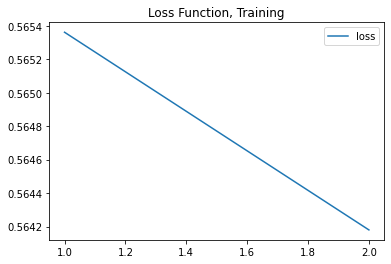

In [52]:
#Vizualize the model plot where the y-axis displays the loss metric

model_plot.plot(
    y="loss",
    title="Loss Function, Training",
    legend="Loss"
)

<AxesSubplot:title={'center':'Accuracy Function, Training'}>

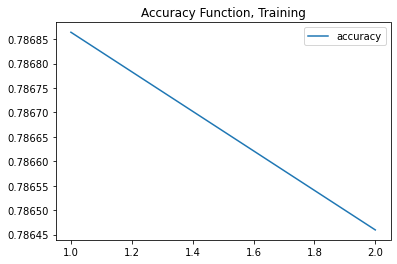

In [53]:
# Vizualize the model plot where the y-axis displays the accuracy metric

model_plot.plot(
    y="accuracy",
    title="Accuracy Function, Training",
    legend="Accuracy"
)

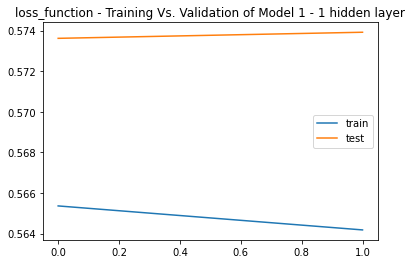

In [54]:
# Train versus validation loss to look for signs of overfitting

plt.plot(model_1.history["loss"])
plt.plot(model_1.history["val_loss"])
plt.title("loss_function - Training Vs. Validation of Model 1 - 1 hidden layer")
plt.legend(["train", "test"])
plt.show()

In [55]:
# Evaluate the model loss and accuracy metrics using the evaluate method and the validation data

model_loss, model_accuracy = nn.evaluate(X_validation_scaled, y_validation, verbose=2)

# Display the model loss and accuracy results

print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

97/97 - 0s - loss: 0.5739 - accuracy: 0.7910 - 70ms/epoch - 726us/step
Loss: 0.5739153623580933, Accuracy: 0.7910061478614807


# SECTION 5: Tuning the Sequential Model

## 5.1.) GridSearchCV Hyperparameter Tuning: Epochs and Batch Size

In [ ]:
#Establish stratified k-folds

kfold = StratifiedKFold(n_splits=5, random_state=seed, shuffle=True)

In [ ]:
#Create a function for grid search

def create_model():
    
    model=Sequential()
    model.add(Dense(7, input_dim=13, activation="relu"))
    model.add(Dense(7, activation="relu"))
    model.add(Dense(6, activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy",
                    optimizer="adam",
                    metrics=["accuracy"])
    return model

In [ ]:
#Create a function that:
#1/ Creates a dictionary of search parameters and passes it on to the Scikit-learn GridSearchCV estimator,
#2/ Fits the model
#3/ Makes predictions 

def algorithm_trial(X_train, X_validation, y_train, y_validation, 
                       model, param_grid, cv=kfold, scoring_fit='accuracy',
                       do_probabilities = False):
    
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=2
    )
    fitted_model = gs.fit(X_train, y_train, callbacks=[keras.callbacks.EarlyStopping(patience=10)])
    
    if do_probabilities:
      pred = fitted_model.predict_proba(X_validation)
    else:
      pred = fitted_model.predict(X_validation)
    
    return fitted_model, pred

In [ ]:
#Establish parameter grid for number of epochs and batch size

param_grid = {
              'epochs':[600, 800, 1000, 1200],
              'batch_size': [12, 24, 32, 75, 100, 120],
             }

In [ ]:
#Create the KerasClassifier object

model = KerasClassifier(build_fn = create_model, verbose=0)

In [ ]:
#Run grid search to find best parameters

model, pred = algorithm_trial(X_train_scaled, X_validation_scaled, y_train, y_validation, model, 
                                        param_grid, cv=kfold, scoring_fit='accuracy')

print(model.best_score_)
print(model.best_params_)

## 5.2.) Creating Neural Network Architecture

In [ ]:
#Define the the number of inputs (features) to the model

number_input_features = len(X_train.iloc[0])

#Review the number of features

number_input_features


In [ ]:
#Define the number of neurons in the output layer

number_output_neurons = 1

In [ ]:
#Define the number of hidden nodes for the first hidden layer

hidden_nodes_layer1 = (number_input_features + 1) // 2 

#Review the number hidden nodes in the first layer

hidden_nodes_layer1


In [ ]:
#Define the number of hidden nodes for the second hidden layer

hidden_nodes_layer2 = (hidden_nodes_layer1 + 1) // 2 

# Review the number hidden nodes in the second layer

hidden_nodes_layer2


In [ ]:
#Create the Sequential model instance

nn = Sequential()

In [ ]:
# Add the first hidden layer

nn.add(Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))

In [ ]:
#Add the second hidden layer

nn.add(Dense(units=hidden_nodes_layer2, activation="relu"))

In [ ]:
#Add the output layer to the model specifying the number of output neurons and activation function
#Using Softmax because of multi-class classification

nn.add(Dense(units=1, activation="softmax"))


In [ ]:
#Display the Sequential model summary

nn.summary()


## 5.3.) Compiling Neural Network Architecture

In [ ]:
#Compile the Sequential model
#Using Sparce Categorical Crossentropy because of multi-class classification

nn.compile(loss="sparce_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])


In [ ]:
#Fit the model using 50 epochs and the training data

model_2 = nn.fit(X_train_scaled, y_train, epochs=50)


## 5.4.) Evaluating the Model for Loss and Accuracy

In [ ]:
#Create a DataFrame using the model history and an index parameter

model_plot = pd.DataFrame(model_2.history, index=range(1, len(model_2.history["loss"]) + 1))

In [ ]:
#Vizualize the model plot where the y-axis displays the loss metric

model_plot.plot(
    y="loss",
    title="Loss Function, Training",
    legend="Loss"
)

In [ ]:
# Vizualize the model plot where the y-axis displays the accuracy metric

model_plot.plot(
    y="accuracy",
    title="Accuracy Function, Training",
    legend="Accuracy"
)

In [ ]:
# Train versus validation loss to look for signs of overfitting

plt.plot(model_2.history["loss"])
plt.plot(model_2.history["val_loss"])
plt.title("loss_function - Training Vs. Validation of Model 2 - 1 hidden layer")
plt.legend(["train", "test"])
plt.show()

In [ ]:
# Evaluate the model loss and accuracy metrics using the evaluate method and the validation data

model_loss, model_accuracy = nn.evaluate(X_validation_scaled, y_validation, verbose=2)

# Display the model loss and accuracy results

print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

In [ ]:
#Getting predictions (predicted probability of being in each category)

y_proba = nn.predict(X_validation_scaled)
y_proba.round(2)

In [ ]:
#Forming DataFrame with probabilities

proba_df = pd.DataFrame(y_proba.round(2))

In [ ]:
#Formatting probabilities DataFrame

proba_df["Actual"] = y_validation
proba_df.columns = ["'Strong Sell' Probability Estimate", "'Sell' Probability Estimate", "'Pass' Probability Estimate", "Actual", "'Buy' Probability Estimate", "'Strong Buy' Probability Estimate"]
proba_df

In [ ]:
#Labeling caterogires

proba_df.loc[proba_df["Actual"] == 0, "Actual"] = "Strong Sell"
proba_df.loc[proba_df["Actual"] == 1, "Actual"] = "Sell"
proba_df.loc[proba_df["Actual"] == 2, "Actual"] = "Pass"
proba_df.loc[proba_df["Actual"] == 1, "Actual"] = "Buy"
proba_df.loc[proba_df["Actual"] == 2, "Actual"] = "Strong Buy"

# SECTION 5: Comparing the Models


In [ ]:
#Comparing loss of both models

plt.plot(model_1.history["loss"])
plt.plot(model_2.history["loss"])
plt.title("loss_function - Training")
plt.legend(["1 hidden layer", "2 hidden layers"])
plt.show()